# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [1]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats

gs.random.seed(2021)

INFO: Using numpy backend


In [2]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
rescale = True
print(f"Will save figs to {figs_dir}")

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 650


The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [4]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


The size of each class is displayed below:

In [5]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


The above code also created a dictionnary `ds`, that contains the cell boundaries data sorted by `treatment` and cell `line`. To access all the cells corresponding to a given treatment and a given cell line, we use the syntax `ds[treatment][line]` as in the following code that computes the number of cells in the cytd-dlm8 class.

In [6]:
len(ds["cytd"]["dlm8"])

82

We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [7]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [8]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(1116.1964538574218,
 1229.1335021972657,
 -283.2620025634766,
 -199.1779998779297)

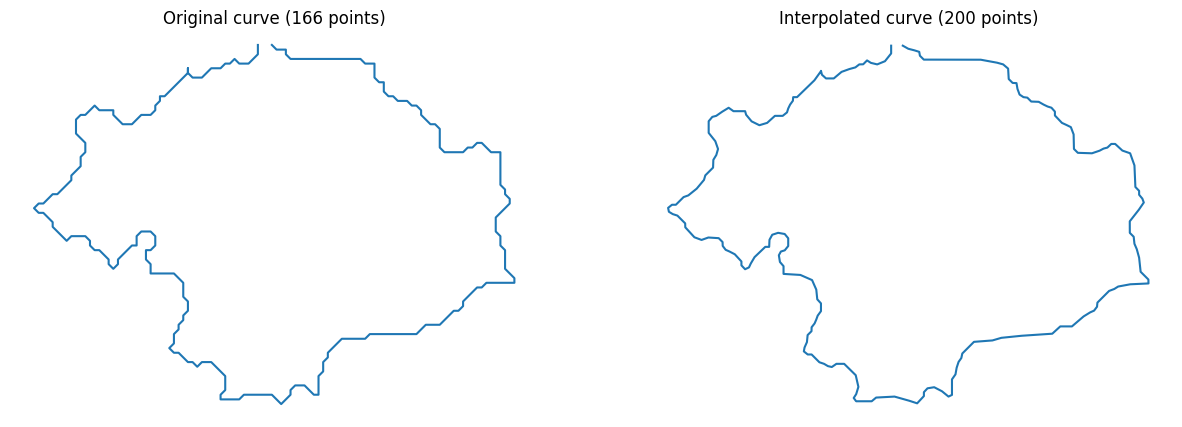

In [9]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
# plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [10]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

For each key treatment-control, we check that the number of sampling points is the one expected, i.e. `k_sampling_points`:

In [11]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

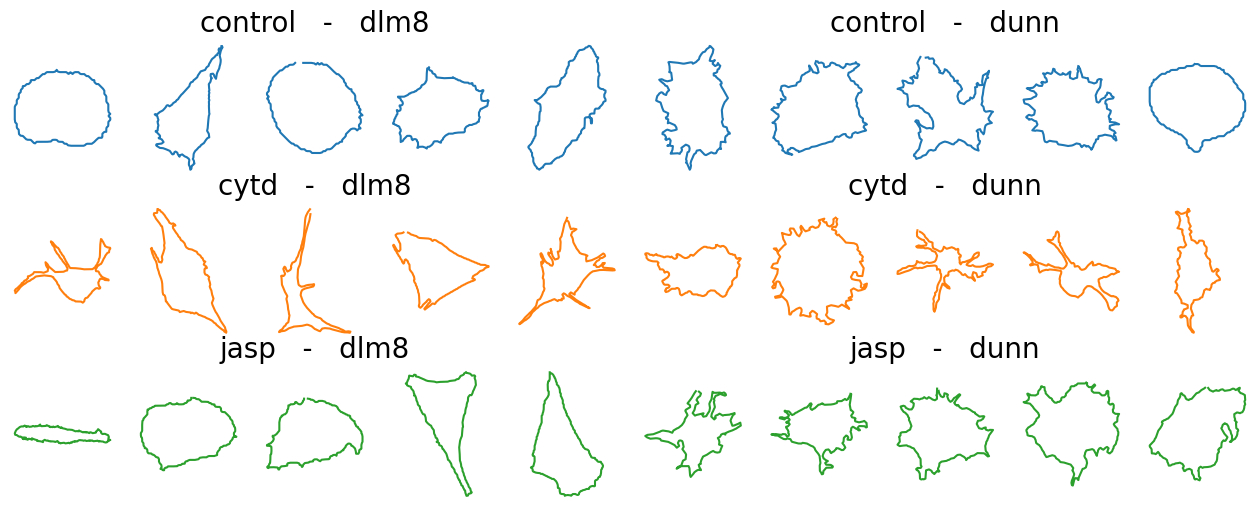

In [12]:
n_cells_to_plot = 5

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            plt.xlim(-170, 170)
            plt.ylim(-170, 170)
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

In [13]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks and reparamterization.

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

This exhaustive search is implemented in the function `exhaustive_align` in `common.py`.

Since the alignment procedure takes 10+ hours, we ran `osteosarocoma_align.py` and saved the results in `~/dyn/datasets/osteosarcoma/aligned`

In [14]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

Write a function to generate unit circle to serve as the base curve.

In [15]:
def generate_circle_points(num_points):
    # Generate angles evenly distributed between 0 and 2*pi
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    
    # Calculate x and y coordinates
    x = np.cos(angles)
    y = np.sin(angles)
    
    # Combine x and y coordinates into a 200x2 array
    points = np.column_stack((x, y))
    
    return points

In [16]:
BASE_CURVE = generate_circle_points(k_sampling_points)


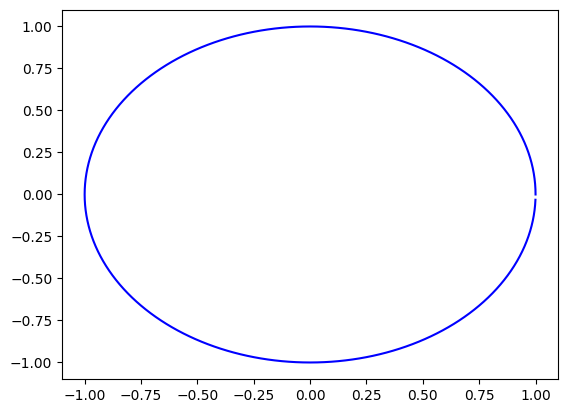

In [17]:
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1], "blue")

For `BASE_CURVE`, we quotiented out translation and rotation for visualizing the alignment

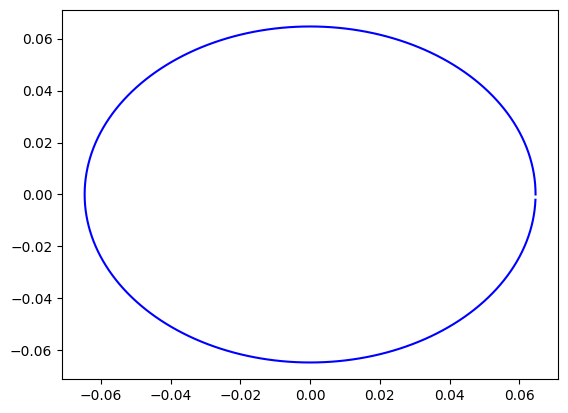

In [18]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
        ambient_dim=2, k_sampling_points=k_sampling_points+1, equip=False
    )
ref_curve = curves_r2.projection(BASE_CURVE)

ref_curve = curves_r2.normalize(BASE_CURVE)
plt.plot(ref_curve[:, 0], ref_curve[:, 1], "blue")

Compute the alignment between cells in the osteosarcoma datast and the `BASE_CURVE`

In [26]:
BASE_CURVE = ds_proc["control"]["dlm8"][0]

rescale = True
reparameterization = True
dynamic = True

treatment = 'control'
line = 'dlm8'
index = 42
unaligned_cell = ds_proc[treatment][line][index]

In [27]:
aligned_cell = exhaustive_align(unaligned_cell, BASE_CURVE, k_sampling_points, rescale=rescale, reparameterization=reparameterization, dynamic=dynamic)

Use dynamic programming aligner
Quotientint out translation
Quotientint out rescaling
Quotienting out rotation and reparamterization


We quotiented out translation and rescaling from the original cell to visualize the effect of alignment

In [28]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
        ambient_dim=2, k_sampling_points=k_sampling_points+1, equip=False
    )
curves_r2.fiber_bundle = SRVReparametrizationBundle(curves_r2)
curves_r2.fiber_bundle.aligner = DynamicProgrammingAligner()
# partial_unaligned_cell = curves_r2.projection(unaligned_cell)

print(curves_r2.length(unaligned_cell))
partial_unaligned_cell = curves_r2.normalize(unaligned_cell)
print(curves_r2.length(partial_unaligned_cell))
print(curves_r2.length(ref_curve))

24059.376508985668
1.0
0.9999999999999997


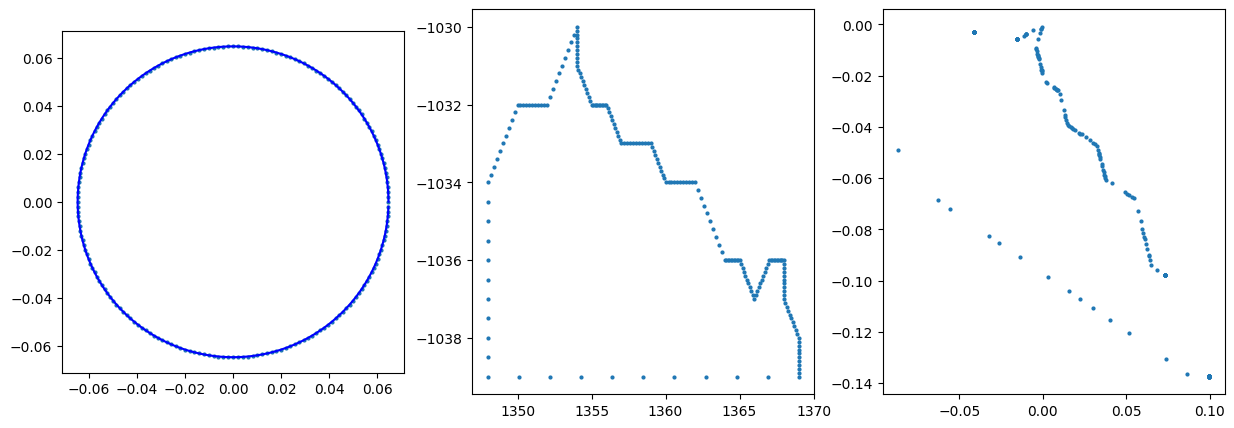

In [29]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
ax = plt.gca()
ax.set_aspect('equal')
plt.plot(ref_curve[:, 0], ref_curve[:, 1], "blue")
plt.scatter(ref_curve[:, 0], ref_curve[:, 1], s=4)

fig.add_subplot(132)
ax = plt.gca()
# ax.set_aspect('equal')
# plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1], "black")
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4)

fig.add_subplot(133)
ax = plt.gca()
# ax.set_aspect('equal')
# plt.plot(aligned_cell[:, 0], aligned_cell[:, 1], "red")
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4)

In [23]:
print(aligned_cell)

[[-0.00301678 -0.00714777]
 [-0.0044067  -0.00807986]
 [-0.00588809 -0.009028  ]
 [-0.00590319 -0.00904842]
 [-0.02594135 -0.01984989]
 [-0.02614423 -0.02140326]
 [-0.03753078 -0.0338303 ]
 [-0.03784772 -0.03564122]
 [-0.0380375  -0.03781365]
 [-0.03809665 -0.03877043]
 [-0.03815351 -0.03963504]
 [-0.03853603 -0.04255512]
 [-0.04189965 -0.04758319]
 [-0.04657398 -0.04972478]
 [-0.04659612 -0.05115963]
 [-0.04572273 -0.05607383]
 [-0.0472536  -0.06239373]
 [-0.04698842 -0.06380935]
 [-0.04689769 -0.06439685]
 [-0.04825497 -0.06943284]
 [-0.04827762 -0.06955526]
 [-0.04833901 -0.07025816]
 [-0.04922788 -0.07305357]
 [-0.05062675 -0.07561484]
 [-0.04559691 -0.08931952]
 [-0.04533229 -0.0908402 ]
 [-0.04513414 -0.09337162]
 [-0.04489836 -0.09566851]
 [-0.03333597 -0.10640789]
 [-0.02906827 -0.11208778]
 [-0.02575031 -0.11995233]
 [-0.02669138 -0.14088867]
 [-0.04183104 -0.16309335]
 [-0.04076612 -0.16922451]
 [-0.03761977 -0.17326603]
 [-0.03674715 -0.17713232]
 [-0.0362442  -0.18089796]
 

In [24]:
print(unaligned_cell)

[[ 777.         -266.        ]
 [ 777.         -266.88500977]
 [ 775.46002197 -268.54000854]
 [ 774.3449707  -269.        ]
 [ 773.46002197 -269.54000854]
 [ 770.02502441 -270.        ]
 [ 766.         -270.61999512]
 [ 765.80499268 -272.19500732]
 [ 764.84002686 -273.        ]
 [ 763.07000732 -273.        ]
 [ 762.15002441 -273.8500061 ]
 [ 762.         -274.73498535]
 [ 760.76000977 -276.23999023]
 [ 760.         -278.51501465]
 [ 759.2199707  -280.77999878]
 [ 757.45001221 -282.        ]
 [ 756.         -282.48001099]
 [ 755.95501709 -285.04501343]
 [ 755.07000732 -285.92999268]
 [ 755.         -288.44500732]
 [ 754.29998779 -289.70001221]
 [ 754.         -290.58499146]
 [ 753.05999756 -291.94000244]
 [ 752.         -293.70999146]
 [ 752.47998047 -295.48001099]
 [ 754.         -297.5       ]
 [ 754.02001953 -301.01998901]
 [ 755.78997803 -302.79000854]
 [ 756.         -303.77999878]
 [ 756.66497803 -304.66500854]
 [ 757.54998779 -305.        ]
 [ 758.43499756 -305.43499756]
 [ 759. 

In [25]:
# for treatment in TREATMENTS:
#     for line in LINES:
#         cells = ds_proc[treatment][line]
#         for i, cell in enumerate(cells):
#             try:
#                 aligned_cell = exhaustive_align(cell, BASE_CURVE, k_sampling_points, rescale=rescale, reparameterization=reparameterization, dynamic=False)
#                 file_path = os.path.join(data_folder, f"{treatment}_{line}_{i}.txt")
#                 np.savetxt(file_path, aligned_cell)
#             except Exception:
#                 print("enter Exception")
#                 pass